In [1]:
%matplotlib inline
import os, ipfix, imp, math
import pandas as pd
import numpy as np

import graph, loader, config, template, locations
from misc import stop

# init IE specs
ipfix.ie.use_iana_default()
ipfix.ie.use_5103_default()
ipfix.ie.use_specfile("qof.iespec")
ipfix.ie.use_specfile("copycat.iespec")
ipfix.types.use_integer_ipv4()

# init campaign variables
output_dir  = "plots/"
campaign_id = "sch1-0002-t3-f2-1" 
all_cids1 = ["sch1-0002-t3-f1-1", "sch1-0002-t3-f1-2", "sch1-0002-t3-f1-3"]#, "sch1-0002-t3-f1-4"]
all_cids2 = ["sch1-0002-t3-f2-1", "sch1-0002-t3-f2-2", "sch1-0002-t3-f2-3"]#,"sch1-0002-t3-f2-4"]
all_cids3 = ["sch1-0003-t3-f1-4", "sch1-0003-t3-f2-4"]
all_cids=all_cids1+all_cids2+all_cids3 

In [2]:
# load reorder density 
rd = loader.load_rd(all_cids)
udp_rd = rd.reset_index()

ind = ["sourceIPv4Address", "destinationIPv4Address", 
       "copycatRunId", 
       "copycatFileSize", "copycatPacketSize"]
ies = ind+["rd", "occurence"]

In [ ]:
udp_rd = this_rd
ind = ["sourceIPv4Address", "destinationIPv4Address", 
       "copycatRunId", "copycatFileSize"]
tcp, udpc, udps = loader.load_df(all_cids,
                                 [],
                                 ["tcpSequenceJumpCount", "reverseTcpSequenceJumpCount"],
                                 ind,
                                 load_udps=False, load_udpc=False,
                                 offset=3)

In [ ]:
tcp_rd = tcp["reverseTcpSequenceJumpCount"]
tcp_rd = tcp_rd.reset_index()
tcp_rd["rd"] = tcp_rd["reverseTcpSequenceJumpCount"] / (tcp_rd["copycatFileSize"] / 1440.0)

In [28]:
from statsmodels.distributions.empirical_distribution import StepFunction

def format_pdf(x, y, log=False, num=10000):
    """
    Format data for cdf plots
    """
    step = StepFunction(x, y)
    xmin=min(x)
    xmax=max(x)
    if log is False:
        x = np.linspace(xmin, xmax, num=num)
    else:
        x = np.logspace(1, 2, num=num)
    y = step(x)
    return x, y

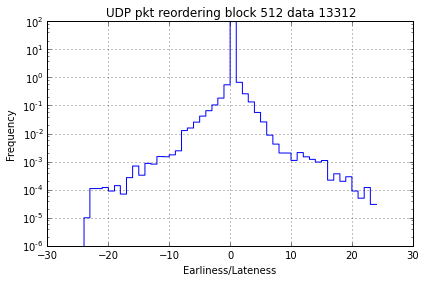

SystemExit: 0

To exit: use 'exit', 'quit', or Ctrl-D.


In [31]:
import pylab as p
imp.reload(graph)

def clipper(x):
    if x > xlim:
        x = xlim
    elif x < -xlim:
        x = -xlim
    return x

for filesize in set(this_rd.copycatFileSize):
    for packetsize in set(this_rd.copycatPacketSize):
        ies = ["rd", "occurence"]
        this_pkts = this_rd[(this_rd.copycatFileSize == filesize) & (this_rd.copycatPacketSize == packetsize)][ies]
        if len(this_pkts) == 0:
            continue
        x = []
        y = []
        total_pkts = float(this_pkts.occurence.sum())
        for k,d in this_pkts.rd.value_counts().items():
            count   = this_pkts[this_pkts.rd == k].occurence.sum()
            density = (count / total_pkts)*100
            x.append(k)
            y.append(density)
            
        # clip outliers
        xmin = min(x)
        xmax = max(x)
        xlim = min(np.abs(xmin), np.abs(xmax))
        x = list(map(clipper, x))

        graph.cdf((x,y), "UDP pkt reordering block "+str(packetsize)+" data "+str(filesize), 
                  "Earliness/Lateness", "Frequency", 
                  None, num=1000, pdf=True, logy=True, autolimx=True)
        


        stop()

In [67]:
# format data
funcs = []
funcs2 = []
xlabels = []
for filesize in set(this_rd.copycatFileSize):
    for packetsize in set(this_rd.copycatPacketSize):
        ies = ["rd", "occurence"]
        this_pkts = this_rd[(this_rd.copycatFileSize == filesize) & (this_rd.copycatPacketSize == packetsize)][ies]
        if len(this_pkts) == 0:
            continue
        
        data = {}
        total_pkts = float(this_pkts.occurence.sum())
        for k,d in this_pkts.rd.value_counts().items():
            count   = this_pkts[this_pkts.rd == k].occurence.sum()
            density = (count / total_pkts)*100
            val = np.abs(k)
            if val in data:
                data[val] += density
            else:
                data[val] = density

        xlabels.append((filesize, packetsize))
        f = StepFunction(list(data.keys()),list(data.values()))
        #x = np.logspace(1, 2, num=num)
        funcs.append(f)
        funcs2.append(StepFunction(list(data.values()), list(data.keys())))

In [37]:
def gridplot(a, label, cmap="RdBu", vrange=None, file=None, lim=None, title=None, ticks=None):
    p.figure() # figsize=(7,2.5)
    if vrange is None:
        p.pcolor(a, cmap=cmap)
    else:
        p.pcolor(a, cmap=cmap, vmin=vrange[0], vmax=vrange[1])
    if lim:
        p.xlim(lim)
        p.ylim(lim)
    if ticks: 
        p.xticks(ticks,("NA", "EU", "AS", "O")) 
        p.yticks(ticks,("NA", "EU", "AS", "O")) 
    p.ylabel("Frequency")
    p.xlabel("Block/data")
    p.colorbar(label=label)
    if title:
        p.title(title)
    p.tight_layout()
    if file:
        p.savefig(file)


([<matplotlib.axis.YTick at 0x7ff39f246668>,
 <a list of 4 Text yticklabel objects>)

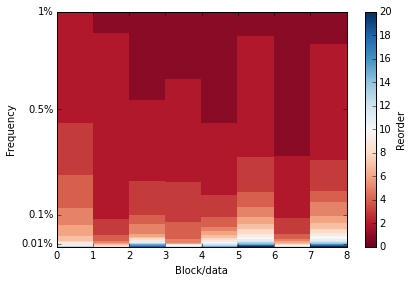

In [66]:
import pylab as p
def superfunc(i, j):
    return funcs2[i](j)
    
xdim = 8
ydim = 10000
x = np.arange(xdim)
y = np.logspace(0,2,num=ydim+1)[1:]-1
data = np.zeros((ydim, xdim))

for i, this_x in enumerate(x):
    for j, this_y in enumerate(y):
        data[j, i] = superfunc(this_x, this_y)

#test = funcs2[0]

gridplot(data, "Reorder", vrange=[0,20])
p.xlim(0,xdim)
p.ylim(0, 1504)
p.yticks([21, 206, 880, 1504],["0.01%", "0.1%", "0.5%", "1%"])
#p.xticks()
#p.pcolor(data)

#superfunc(0, y)

In [84]:
# compute reordering per flow
ind = ["sourceIPv4Address", "destinationIPv4Address",  "destinationTransportPort",
               "copycatRunId", "copycatFileSize", "copycatPacketSize"]
tmp     = udp_rd
tmp.rd  = udp_rd.rd.abs()
udp_rd2 = tmp.groupby(ind).sum()

In [176]:
# create step function of reorder per flow
udp_funcs  = []
tcp_funcs  = []
udp_labels = []
tcp_labels = []
ies = ["rd", "occurence", "sourceIPv4Address", "destinationIPv4Address", 
       "copycatRunId", "copycatFileSize", "copycatPacketSize"]

fsizes = [13312, 39936, 399360, 399300, 4088832]
flabels = {13312: "13Kb", 39936: "39Kb", 399360: "390Kb", 399300: "390Kb", 4088832: "3.9Mb"}
bsizes = [512, 1460]
    
for filesize in fsizes:
    # tcp step
    this_tcp = None
    if filesize == 399360:
        this_tcp = tcp_rd[(tcp_rd.copycatFileSize == 399361) | (tcp_rd.copycatFileSize == 399301)]["reverseTcpSequenceJumpCount"].value_counts()
    elif filesize != 399300:
        this_tcp = tcp_rd[(tcp_rd.copycatFileSize == filesize+1)]["reverseTcpSequenceJumpCount"].value_counts()
    if this_tcp is not None:
        x = list(this_tcp.index)
        y = list(this_tcp.values) / sum(list(this_tcp.values))
        tcp_funcs.append(StepFunction(y, x))
        tcp_labels.append(flabels[filesize])
        
    for packetsize in bsizes:
        # udp step
        this_pkts = udp_rd2[(udp_rd2.copycatFileSize == filesize) & (udp_rd2.copycatPacketSize == packetsize)]["rd"]
        if len(this_pkts) == 0:
            continue
        this_pkts = this_pkts.value_counts()
        x = [i/2.0 for i in list(this_pkts.index)] 
        y = list(this_pkts.values) / sum(list(this_pkts.values))

        udp_labels.append((flabels[filesize], packetsize))
        udp_funcs.append(StepFunction(y, x))

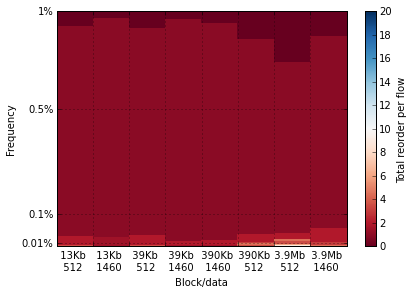

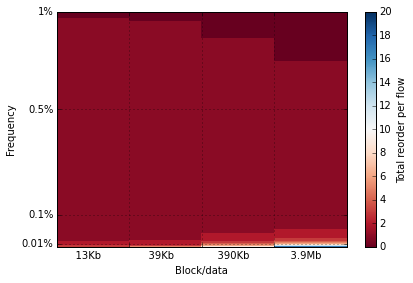

In [178]:
def udpfunc(i, j):
    return udp_funcs[i](j)

def tcpfunc(i, j):
    return tcp_funcs[i](j)
    
# plot UDP reorder per flow
xdim = 8
ydim = 10000
x = np.arange(xdim)
y = np.logspace(0,2,num=ydim+1)[1:]-1
data = np.zeros((ydim, xdim))

for i, this_x in enumerate(x):
    for j, this_y in enumerate(y):
        data[j, i] = udpfunc(this_x, this_y)

#test = funcs2[0]

gridplot(data, "Total reorder per flow", vrange=[0,20])
p.xlim(0,xdim)
p.ylim(0, 1504)
p.yticks([21, 206, 880, 1504],["0.01%", "0.1%", "0.5%", "1%"])
centr = " "*10
p.xticks([0,1,2,3,4,5,6,7,8],[centr+str(i)+"\n"+centr+str(j) for i,j in udp_labels])
p.grid()
p.savefig("plots/udp-rd.pdf")

# plot TCP reorder per flow
xdim = 4
ydim = 10000
x = np.arange(xdim)
y = np.logspace(0,2,num=ydim+1)[1:]-1
data = np.zeros((ydim, xdim))

for i, this_x in enumerate(x):
    for j, this_y in enumerate(y):
        data[j, i] = tcpfunc(this_x, this_y)

#test = funcs2[0]

gridplot(data, "Total reorder per flow", vrange=[0,20])
p.xlim(0,xdim)
p.ylim(0, 1504)
p.yticks([21, 206, 880, 1504],["0.01%", "0.1%", "0.5%", "1%"])
centr = " "*20
p.xticks([0,1,2,3,4],[centr+str(i) for i in tcp_labels])
p.grid()
p.savefig("plots/tcp-rd.pdf")